In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras


In [156]:
df = pd.read_csv('data.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [157]:
df.head()

,Traffic Congestion Rate
Date,
2015-01-01,589
2015-02-01,561
2015-03-01,640
2015-04-01,656
2015-05-01,727


<AxesSubplot:xlabel='Date'>

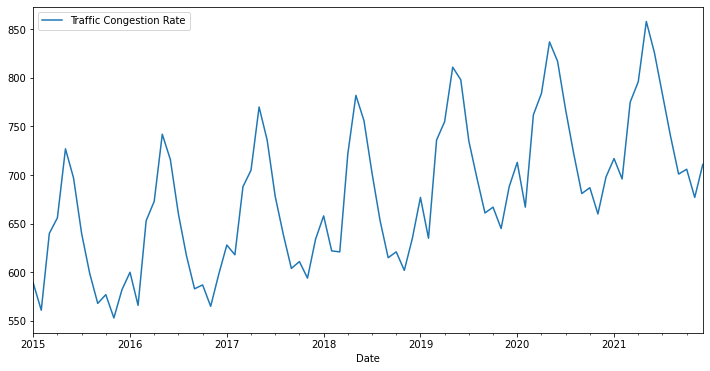

In [158]:
df.plot(figsize=(12,6)) #plotting the figure size and general trend increasing with the time period

In [159]:
from statsmodels.tsa.seasonal import seasonal_decompose #views the exact seasonal rate or seasonal trend , decomposes different part of time series.

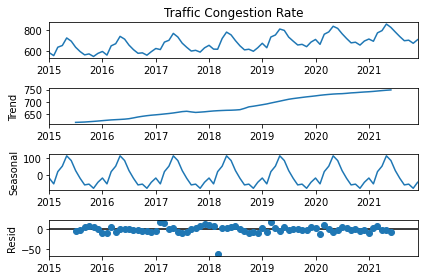

In [160]:
results = seasonal_decompose(df['Traffic Congestion Rate']) #select which coloumn you need decomposition, general increasing trend with time
results.plot();

In [161]:
len(df)

84

In [162]:
train = df.iloc[:72] #uses last 12 months as the testing side , prediction on last 12 months
test = df.iloc[72:]

In [163]:
from sklearn.preprocessing import MinMaxScaler  #used to convert a dataset into a scale of 0 to 1
scaler = MinMaxScaler()

In [164]:
df.head(),df.tail() #There will be a change of magnitude from a particular range to next range , we may get confused so we change it into a length of 0 to 1

(            Traffic Congestion Rate
 Date                               
 2015-01-01                      589
 2015-02-01                      561
 2015-03-01                      640
 2015-04-01                      656
 2015-05-01                      727,
             Traffic Congestion Rate
 Date                               
 2021-08-01                      740
 2021-09-01                      701
 2021-10-01                      706
 2021-11-01                      677
 2021-12-01                      711)

In [165]:
scaler.fit(train) #This will check the mean value maximum value and all , transforming both scalar and testing part
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [166]:
scaled_train[:10] #prints the value in a range of 0 to 1

array([[0.12676056],
       [0.02816901],
       [0.30633803],
       [0.36267606],
       [0.61267606],
       [0.50704225],
       [0.30633803],
       [0.16197183],
       [0.0528169 ],
       [0.08450704]])

In [167]:
from keras.preprocessing.sequence import TimeseriesGenerator #TimesseriesGenerator is used to predict what will happen in the upcoming months

In [168]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [169]:
X,y = generator[0] #3 values are inserted, then will predict the next value
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.12676056 0.02816901 0.30633803]
Predict this y: 
 [[0.36267606]]


In [170]:
X.shape

(1, 3, 1)

In [171]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [172]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [173]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [174]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [175]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
60/60 [==============================] - 1s 3ms/step - loss: 0.1089
Epoch 2/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0511
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0424
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0317
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 8/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0280A: 0s - loss: 0.00
Epoch 9/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 13/50
60/60 [============

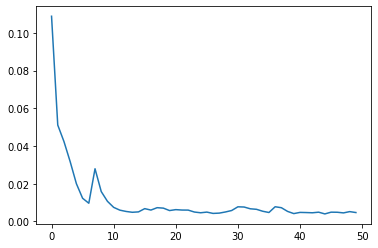

In [176]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [177]:
last_train_batch = scaled_train[-12:]

In [178]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [179]:
model.predict(last_train_batch)

array([[0.5043819]], dtype=float32)

In [180]:
model.predict(last_train_batch)

array([[0.5043819]], dtype=float32)

In [181]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [182]:
test_predictions

[array([0.5043819], dtype=float32),
 array([0.52914643], dtype=float32),
 array([0.7400438], dtype=float32),
 array([0.9071503], dtype=float32),
 array([1.063629], dtype=float32),
 array([1.0279192], dtype=float32),
 array([0.8619136], dtype=float32),
 array([0.6668887], dtype=float32),
 array([0.55021834], dtype=float32),
 array([0.5167339], dtype=float32),
 array([0.48711842], dtype=float32),
 array([0.5203142], dtype=float32)]

In [183]:
test.head()

,Traffic Congestion Rate
Date,
2021-01-01,717
2021-02-01,696
2021-03-01,775
2021-04-01,796
2021-05-01,858


In [151]:
true_predictions = scaler.inverse_transform(test_predictions)

In [152]:
test['Traffic Congestion Rate'] = true_predictions

C:\Users\ctelb\AppData\Local\Temp/ipykernel_15688/301974197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Traffic Congestion Rate'] = true_predictions


<AxesSubplot:xlabel='Date'>

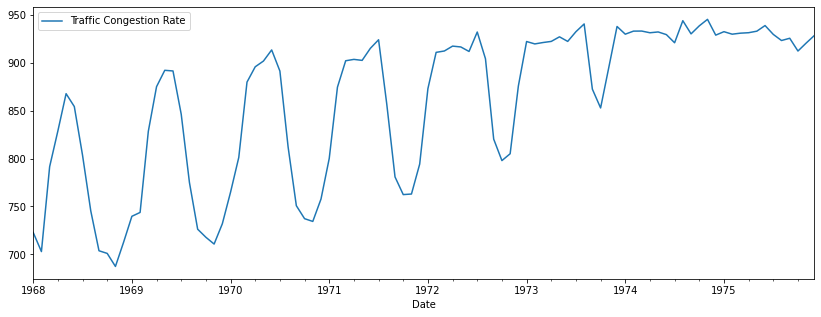

In [153]:
test.plot(figsize=(14,5))

In [154]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

KeyError: 'Production'